In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
import string
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
!pip install tweet-preprocessor
import preprocessor as p
!pip install emoji --upgrade
import emoji
import torch   
import torchtext
from torchtext.legacy import data   
import random

In [ ]:
# location of train set and validation/test set files
train_set_location = r'vaccine_train_set.csv'
validation_set_location = r'vaccine_validation_set.csv'

In [ ]:
EMBEDDING_SIZE = 200 # the dimension of the embedding for every word/token
glove = torchtext.vocab.GloVe(name="twitter.27B", dim=EMBEDDING_SIZE) # download glove file  glove.twitter.27B.200d

#UTILS

In [ ]:
g = torch.Generator()
def reset_seeds(): # reset all random seeds, in order to maintain result reproducability
  torch.manual_seed(0)
  np.random.seed(0)
  g.manual_seed(0)
  random.seed(0)

def seed_worker(worker_id): # function that initializes seeds for the workers of DataLoader
  worker_seed = torch.initial_seed() % 2**32
  numpy.random.seed(worker_seed)
  random.seed(worker_seed)

###### DATA PRE-PROCESSING ####################################################################
p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.NUMBER) # set tweet-preprocessor to remove urls, mentions and numbers

def clean_tweets(data,column):  # function that removes urls, mentions and numbers from all the tweets of the given dataframe
  for i,v in enumerate(data[column]): # for every tweet
      data.loc[i,column] = p.clean(v)
  return data

tweet_tokenizer = TweetTokenizer()   # initialize tweet tokenizer

stop_words = stopwords.words('english') # get english stop words

punctuations = list(string.punctuation) # get puncutations 
punctuations = punctuations + ['–','::','“','’','”','‘','`','...','``']  # add some extra puncutations

def removeEmojis(text): # function that converts emojis to the equivalent text
    text = emoji.demojize(text) # remove emojis
    return str(text) 

def removePuncutation(text):   # remove punctuation from the given text
    text = text.replace("-","")
    splitted = tweet_tokenizer.tokenize(text) # split the tweet into tokens
    new_text = []
    for word in splitted:  # for every token
      if word not in punctuations:    # keep it only if it is not a punctuation
        new_text.append(word)
    text = ' '.join(new_text)
    return text

def removeStopWordsAndPuncs(text):  # remove stop-words and punctuation from the given text
    text = text.replace("-","")
    text = text.replace("::"," ")
    splitted = word_tokenize(text)  # split the tweet into tokens
    new_text = []
    for word in splitted:   # for every token
      if word not in stop_words and word not in punctuations: # keep it only if it is not a punctuation or stop_word
        new_text.append(word)
    text = ' '.join(new_text)
    return text

def clean(text):    # clean the given tweet
    if(CONVERT_TO_LOWERCASE): # if it is enabled
      text = text.lower()  # convert all letters in to lowercase
    if(CLEAN_EMOJIS):
      text = removeEmojis(text)  # convert all emojis to the equivelent text
    if(CLEAN_STOPWORDS and CLEAN_PUNCUATIONS):
      text = removeStopWordsAndPuncs(text)    # remove all punctuation and stopwords
    elif(CLEAN_PUNCUATIONS):
      text = removePuncutation(text)    # remove all punctuation 
    return text

def cleanText(data,column):  # apply clean function to every tweet of the given dataframe
  data[column] = data[column].apply(clean)
  return data

# stemming
ps = SnowballStemmer("english") # intialize stemmer

def stemmTweet(text): # apply stemming to the given tweet
  return ' '.join([(ps.stem) for w \
                       in w_tokenizer.tokenize((text))])  # split the tweet into tokens and apply stemming to every token

def stem_data(data,column): # apply stemming into every tweet of the given dataframe
  data[column] = data[column].apply(stemmTweet)
  return data

lemmatizer = nltk.stem.WordNetLemmatizer()  # initialize Lemmatizer
w_tokenizer =  TweetTokenizer() # initialize tokenizer
 
def lemmatize_text(text): # apply lemmatization to the given tweet
  return ' '.join([(lemmatizer.lemmatize(w)) for w \
                       in word_tokenize((text))])  # split the tweet into tokens and apply lemmatization to every token

def lemmatize_data(data,column): # apply lemmatization into every tweet of the given dataframe
  data[column] = data[column].apply(lemmatize_text)
  return data   
###############################################################################################

###### Data Tokenization ####################################################################
def get_tweet_words(data,labels,glove_vector):
    # function that splits the tweets into tokens, and converts words/tokens to the correspindind index of the embedding
    new_data = []
    for i, tweet in enumerate(data):
        idxs = [glove_vector.stoi[w]        # lookup the index of word
                for w in tweet.lower().split() # split the tweet in tokens
                if w in glove_vector.stoi] # keep words that has an embedding
        if not idxs: # ignore tweets without any word with an embedding
            continue
        idxs = torch.tensor(idxs) # convert list to pytorch tensor
        label = torch.tensor(int(labels[i])).long()
        new_data.append((idxs, label))
    return new_data
###############################################################################################

###### Batcher implementation ####################################################################
class TweetBatcher:
    def __init__(self, tweets, batch_size=32):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length depending on the length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    worker_init_fn=seed_worker,
                                    generator=g,
                                    )
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

def createDataLoaders(trainSet,validSet,batch_size): # create batchers for the train and the validation set
  return TweetBatcher(trainSet, batch_size=batch_size), TweetBatcher(validSet, batch_size=batch_size)
###############################################################################################

def plot_loss_curves(t_loss,v_loss,epochs = 100):
  # function that plots the loss vs epochs curves
  x = list(range(1,epochs+1))
  plt.plot(x, t_loss, 'r',label='Train Loss')
  plt.plot(x, v_loss, 'g',label='Validation Loss')
  plt.legend(loc='best')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Loss vs Epoch curves')
  plt.show()

# BEST LSTM MODEL
Containing:
  - 2 stacked LSTM bidirectional layers with hidden size 8
  - dropout between the layers
  - gradient clipping

RNN(
  (emb): Embedding(1193514, 200)
  (lstm): LSTM(200, 8, num_layers=2, batch_first=True, dropout=0.6, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16, out_features=3, bias=True)
)
Epoch   0: Train Loss = 1.05846 | Validation Loss = 0.98044 | Accuracy = 57.9316 | Train-f1 = 0.3932 | Valid-F1 = 0.5400
Epoch   1: Train Loss = 0.97967 | Validation Loss = 0.90927 | Accuracy = 64.0228 | Train-f1 = 0.4929 | Valid-F1 = 0.5977
Epoch   2: Train Loss = 0.91002 | Validation Loss = 0.84433 | Accuracy = 65.2498 | Train-f1 = 0.5686 | Valid-F1 = 0.6109
Epoch   3: Train Loss = 0.86623 | Validation Loss = 0.80854 | Accuracy = 65.4689 | Train-f1 = 0.5896 | Valid-F1 = 0.6128
Epoch   4: Train Loss = 0.83475 | Validation Loss = 0.79531 | Accuracy = 65.9509 | Train-f1 = 0.6106 | Valid-F1 = 0.6211
Epoch   5: Train Loss = 0.81846 | Validation Loss = 0.77619 | Accuracy = 66.8273 | Train-f1 = 0.6219 | Valid-F1 = 0.6385
Epoch   6: Train Loss = 0.80610 | Validation 

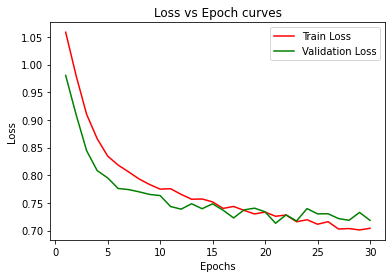

 Accuracy: 69.37%
 f1 score: 68.89%
 Precision: 69.12%
 Recall: 69.37%
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1065
           1       0.48      0.34      0.40       296
           2       0.65      0.75      0.70       921

    accuracy                           0.69      2282
   macro avg       0.64      0.61      0.62      2282
weighted avg       0.69      0.69      0.69      2282



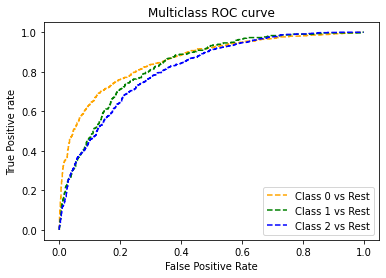

In [ ]:
trainSet = pd.read_csv(train_set_location,index_col=0)  # read csv file and store it to a dataframe
validationSet = pd.read_csv(validation_set_location,index_col=0)  # read csv file and store it to a dataframe


CLEAN_ULR_MENTIONS_NUMBERS = True   # remove urls, mentions and numbers from tweets
CLEAN_STOPWORDS = True # remove stopwords from tweets
CLEAN_EMOJIS = True # convert emojis to the equivelent text
CLEAN_PUNCUATIONS = True  # remove punctuation from tweets
CONVERT_TO_LOWERCASE = True # convert all text to lowercase
LEMMATIZATION = True # apply lemmatization to the tweets
STEMMING = False   # apply stemming to the tweets
   

if(CLEAN_ULR_MENTIONS_NUMBERS):
  trainSet = clean_tweets(trainSet,'tweet') # remove urls, mentions, numbers from all the tweets in the train set
  validationSet = clean_tweets(validationSet,'tweet') # remove urls, mentions, numbers from all the tweets in the validation set
if(CLEAN_EMOJIS or CLEAN_STOPWORDS or CLEAN_PUNCUATIONS or CONVERT_TO_LOWERCASE):
  trainSet = cleanText(trainSet,'tweet')    # clean the tweets of the train set 
  validationSet = cleanText(validationSet,'tweet')    # clean the tweets of the validation set 
if(LEMMATIZATION):
  trainSet = lemmatize_data(trainSet,'tweet') # apply lemmatization to all the tweets of the train set
  validationSet = lemmatize_data(validationSet,'tweet')  # apply lemmatization to all the tweets of the validation set
if(STEMMING):
  trainSet = stem_data(trainSet,'tweet')   # apply stemming to all the tweets of the train set
  validationSet = stem_data(validationSet,'tweet')   # apply stemming to all the tweets of the validation set

X_train = list(trainSet['tweet']) # convert the tweets of the train set into a list
y_train = list(trainSet['label']) # convert the labels of the train set into a list

X_validation = list(validationSet['tweet']) # convert the tweets of the validation set into a list
y_validation = list(validationSet['label']) # convert the labels of the validation set into a list

train_set_transformed = get_tweet_words(X_train,y_train,glove) # tokenize the train set and convert tokens/words to the corresponding embedding index
validation_set_transformed = get_tweet_words(X_validation,y_validation,glove) # tokenize the validation set and convert tokens/words to the corresponding embedding index

# the RNN implementation
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_between_layers, final_dropout,bidirectional):
        super(RNN, self).__init__()
        self.num_layers = num_layers # number of stacked layers
        self.hidden_size = hidden_size # hidden size of every layer
        self.emb = nn.Embedding.from_pretrained(glove.vectors) # embedding layer (not trainable) using pre-trained glove word embeddings
        if(num_layers==1): # if we only have one layer, the dropout between stacked layers is not defined
          dropout_between_layers = 0
        if model_type=='LSTM': # if the cell type is set to LSTM
          # define the stacked bidirectional LSTM layers
          self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_between_layers,bidirectional=bidirectional)
        elif model_type=='GRU': # if the cell type is set to GRU
          self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_between_layers,bidirectional=bidirectional)
        else: # else define classic RNN cell
          self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_between_layers,bidirectional=bidirectional)

        self.dropout = nn.Dropout(final_dropout) # dropout layer after the last LSTM/GRU layer
        self.fc = nn.Linear(hidden_size*2, num_classes) # linear output layer
        
        self._init_weights() # initialize all the weights
        
    def forward(self, x):
        x = self.emb(x) # create the embeddings of the tweets
        # Set initial hidden states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device) 
        if model_type=='LSTM':
          # Set initial cell states for LSTM
          c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(device)
          out, _ = self.lstm(x, (h0,c0))  # lstm stacked bidirectional layers
        elif model_type=='GRU':
          out, _ = self.gru(x, h0)  # gru stacked bidirectional layers
        else:
          out, _ = self.rnn(x, h0) 
        
        out = self.dropout(out) # dropout after the last LSTM/GRU layer
        out = out[:, -1, :] # reshape the output
         
        out = self.fc(out) # linear output layer, in order to create output of size 3 (number of classes).
        return out
    
    def _init_weights(self):
        # function that initializes all the model weights
        if model_type=='LSTM':
          params = self.lstm.parameters()
        elif model_type=='GRU':
          params = self.gru.parameters()
        else:
          params = self.rnn.parameters()
        for param in params:
            # Keep track of gradient for backprop
            param.requires_grad_(True)
            # If we deal with weights xavier initialization
            if param.data.ndimension() >= 2:
                nn.init.xavier_uniform_(param.data) #keep variance stability
            # Else is a bias term so all zeros
            else: 
                nn.init.zeros_(param.data)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reset_seeds() # reset all random seeds
# Hyper-parameters 
num_classes = 3
num_epochs = 30
batch_size = 16
learning_rate = 0.000125

input_size = EMBEDDING_SIZE
hidden_size = 8
num_layers = 2
dropout_between_layers = 0.6
final_dropout = 0.5
gradient_clipping = True
bidirectional = True

model_type = 'LSTM'
# create Batchers/DataLoaders for the train and the validation set
train_loader, validation_loader = createDataLoaders(train_set_transformed, validation_set_transformed,batch_size)
# define the model
model = RNN(input_size, hidden_size, num_layers, num_classes,dropout_between_layers,final_dropout,bidirectional).to(device)
print(model)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = [] # store the train loss for every epoch
valid_loss = []  # store the validation loss for every epoch
for epoch in range(num_epochs):
  train_batch_losses = [] # store the loss of every batch of the train set
  validation_batch_losses = [] # store the loss of every batch of the validation set
  model.train() # set the model to training mode
  y_total_predict_train = []   # store the predictions of the the train set
  y_total_train = []     # store the labels of the the train set
  train_loader_size = 0
  for x_batch, y_batch in train_loader:
    x_batch = x_batch.to(device) # use gpu
    y_batch = y_batch.to(device) # use gpu
    #Delete previously stored gradients
    optimizer.zero_grad()
    z = model(x_batch)
    loss = criterion(z, y_batch)  # compute the train loss
    train_batch_losses.append(loss.data.item()) # store the train loss of the current batch
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    # Step
    # -----------------------------------
    # Clip params
    if gradient_clipping:
      for param in model.parameters():
          if param.grad is None:
              continue
          grad_val = torch.clamp(param.grad, -5, 5)
    optimizer.step()
    # -----------------------------------
    _, y_pred_tags = torch.max(z, dim = 1)  # get the prediction based on the maximum posibility
    y_total_predict_train = y_total_predict_train+ list(y_pred_tags.cpu()) # store the predictions of the current batch
    y_total_train = y_total_train + (list(y_batch.cpu().detach().numpy())) # store the labels of the current batch
    train_loader_size += 1
  with torch.no_grad():
    correct = 0
    count = 0
    valid_loader_count = 0
    model.eval()   # set the model to evaluation mode
    y_total_valid = []   # store the predictions of the the validation set
    y_total_predict_valid = []      # store the labels of the the validation set
    for x_batch, y_batch in validation_loader:
      y_batch = y_batch.to(device) # use gpu
      x_batch = x_batch.to(device) # use gpu
      z = model(x_batch)
      loss = criterion(z, y_batch)   # compute the validation loss
      validation_batch_losses.append(loss.data.item())   # store the validation loss of the current batch
      _, label = torch.max(z,1)    # get the label prediction based on the maximum posibility
      correct += (label==y_batch).sum().item()    # compute how many corect preditions were made
      count += len(y_batch)
      y_total_predict_valid = y_total_predict_valid+ list(label.cpu()) # store the predictions of the current batch
      y_total_valid= y_total_valid + list(y_batch.cpu().detach().numpy()) # store the labels of the current batch
      valid_loader_count += 1
  accuracy = 100*(correct/(count))  # compute validation accuracy based on the correct predictions
  current_train_loss = sum(train_batch_losses)/train_loader_size  #compute the train loss of this epoch
  train_loss.append(current_train_loss)   # store the train loss in order to plot loss curves
  current_valid_loss = sum(validation_batch_losses)/valid_loader_count   #compute the validation loss of this epoch
  valid_loss.append(current_valid_loss)   # store the validation loss in order to plot loss curves
  f1_score_train = f1_score(y_total_train,y_total_predict_train,average='weighted')# compure train f1-score
  f1_score_valid = f1_score(y_total_valid,y_total_predict_valid,average='weighted') # compure validation f1-score
  print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_valid_loss:.5f} | Accuracy = {accuracy:.4f} | Train-f1 = {f1_score_train:.4f} | Valid-F1 = {f1_score_valid:.4f}")

# plot the loss vs epochs curves
plot_loss_curves(train_loss,valid_loss,num_epochs) 

with torch.no_grad():
  model.eval()   # set the model to evaluation mode
  y_total_valid = []   # store the predictions of the the validation set
  y_total_predict_valid = []      # store the labels of the the validation set
  y_output = []
  for x_batch, y_batch in validation_loader:
    x_batch = x_batch.to(device) # use gpu
    y_batch = y_batch.to(device) # use gpu
    z = model(x_batch)
    _, label = torch.max(z,1)    # get the label prediction based on the maximum posibility
    y_output = y_output + list(z.cpu().detach().numpy())
    y_total_predict_valid = y_total_predict_valid+ list(label.cpu()) # store the predictions of the current batch
    y_total_valid= y_total_valid + list(y_batch.cpu().detach().numpy()) # store the labels of the current batch


# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

y_output = np.array(y_output)
n_class = 3  # number of classes/labels

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_total_valid, y_output[:,i], pos_label=i)
    
# plotting the ROC curves
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

y_pred_tags = y_total_predict_valid
accuracy_countVec = accuracy_score(y_total_valid,y_pred_tags)  # accuracy metric
f1_score_countVec = f1_score(y_total_valid,y_pred_tags,average='weighted') # f1_score metric
print(" Accuracy: %.2f%%" %(accuracy_countVec*100))
print(" f1 score: %.2f%%" %(f1_score_countVec*100))
print(' Precision: %.2f%%' % (precision_score(y_total_valid, y_pred_tags,average='weighted')*100)) # precision
print(' Recall: %.2f%%' % (recall_score(y_total_valid, y_pred_tags,average='weighted')*100)) # recall
print(classification_report(y_total_valid, y_pred_tags))

# Best GRU model
Containing:
  - 2 stacked GRU bidirectional layers with hidden size 8
  - dropout between the layers
  - skip connections
  - gradient clipping

RNN(
  (emb): Embedding(1193514, 200)
  (gru1): GRU(200, 8, batch_first=True, bidirectional=True)
  (dropout_between_layers): Dropout(p=0.5, inplace=False)
  (gru2): GRU(16, 8, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Epoch   0: Train Loss = 1.00958 | Validation Loss = 0.96145 | Accuracy = 54.3821 | Train-f1 = 0.4432 | Valid-F1 = 0.4994
Epoch   1: Train Loss = 0.95595 | Validation Loss = 0.91095 | Accuracy = 58.0631 | Train-f1 = 0.4940 | Valid-F1 = 0.5373
Epoch   2: Train Loss = 0.90353 | Validation Loss = 0.85148 | Accuracy = 61.9632 | Train-f1 = 0.5425 | Valid-F1 = 0.5778
Epoch   3: Train Loss = 0.85439 | Validation Loss = 0.80817 | Accuracy = 64.7677 | Train-f1 = 0.5805 | Valid-F1 = 0.6061
Epoch   4: Train Loss = 0.82404 | Validation Loss = 0.79489 | Accuracy = 64.8554 | Train-f1 = 0.5983 | Valid-F1 = 0.6059
Epoch   5: Train Loss = 0.80344 | Validation Loss = 0.76991 | Accuracy = 65.

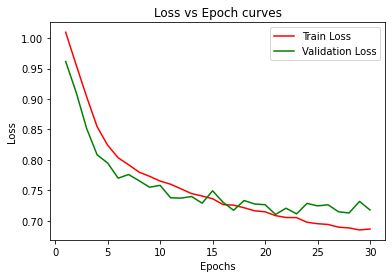

 Accuracy: 69.68%
 f1 score: 69.30%
 Precision: 69.57%
 Recall: 69.68%
              precision    recall  f1-score   support

           0       0.79      0.74      0.77      1065
           1       0.51      0.37      0.43       296
           2       0.65      0.75      0.69       921

    accuracy                           0.70      2282
   macro avg       0.65      0.62      0.63      2282
weighted avg       0.70      0.70      0.69      2282



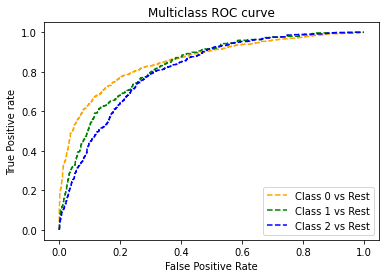

In [ ]:
trainSet = pd.read_csv(train_set_location,index_col=0)  # read csv file and store it to a dataframe
validationSet = pd.read_csv(validation_set_location,index_col=0)  # read csv file and store it to a dataframe


CLEAN_ULR_MENTIONS_NUMBERS = True   # remove urls, mentions and numbers from tweets
CLEAN_STOPWORDS = True # remove stopwords from tweets
CLEAN_EMOJIS = True # convert emojis to the equivelent text
CLEAN_PUNCUATIONS = True  # remove punctuation from tweets
CONVERT_TO_LOWERCASE = True # convert all text to lowercase
LEMMATIZATION = True # apply lemmatization to the tweets
STEMMING = False   # apply stemming to the tweets
   

if(CLEAN_ULR_MENTIONS_NUMBERS):
  trainSet = clean_tweets(trainSet,'tweet') # remove urls, mentions, numbers from all the tweets in the train set
  validationSet = clean_tweets(validationSet,'tweet') # remove urls, mentions, numbers from all the tweets in the validation set
if(CLEAN_EMOJIS or CLEAN_STOPWORDS or CLEAN_PUNCUATIONS or CONVERT_TO_LOWERCASE):
  trainSet = cleanText(trainSet,'tweet')    # clean the tweets of the train set 
  validationSet = cleanText(validationSet,'tweet')    # clean the tweets of the validation set 
if(LEMMATIZATION):
  trainSet = lemmatize_data(trainSet,'tweet') # apply lemmatization to all the tweets of the train set
  validationSet = lemmatize_data(validationSet,'tweet')  # apply lemmatization to all the tweets of the validation set
if(STEMMING):
  trainSet = stem_data(trainSet,'tweet')   # apply stemming to all the tweets of the train set
  validationSet = stem_data(validationSet,'tweet')   # apply stemming to all the tweets of the validation set

X_train = list(trainSet['tweet']) # convert the tweets of the train set into a list
y_train = list(trainSet['label']) # convert the labels of the train set into a list

X_validation = list(validationSet['tweet']) # convert the tweets of the validation set into a list
y_validation = list(validationSet['label']) # convert the labels of the validation set into a list

train_set_transformed = get_tweet_words(X_train,y_train,glove) # tokenize the train set and convert tokens/words to the corresponding embedding index
validation_set_transformed = get_tweet_words(X_validation,y_validation,glove) # tokenize the validation set and convert tokens/words to the corresponding embedding index

# the RNN implementation
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_between_layers, final_dropout,bidirectional):
        super(RNN, self).__init__()
        self.num_layers = num_layers # number of stacked layers
        self.hidden_size = hidden_size # hidden size of every layer
        self.emb = nn.Embedding.from_pretrained(glove.vectors) # embedding layer (not trainable) using pre-trained glove word embeddings
        if(num_layers==1): # if we only have one layer, the dropout between stacked layers is not defined
          dropout_between_layers = 0
        if model_type=='LSTM': # if the cell type is set to LSTM
          # we implement 2 stacked LSTM layers
          self.lstm1 = nn.LSTM(input_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) # first LSTM layer
          self.dropout_between_layers = nn.Dropout(dropout_between_layers) # dropout between the stacked LSTM layers
          self.lstm2 = nn.LSTM(2*hidden_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) # second LSTM layer
        elif model_type=='GRU': # if the cell type is set to GRU
          # we implement 2 stacked GRU layers
          self.gru1 = nn.GRU(input_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) # first GRU layer
          self.dropout_between_layers = nn.Dropout(dropout_between_layers) # dropout between the stacked GRU layers
          self.gru2 = nn.GRU(2*hidden_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) # second GRU layer
      
        self.dropout = nn.Dropout(final_dropout) # dropout layer after the last LSTM/GRU layer
        if skip_connections: # if we apply skip connections
          # the input of the linear output layer is 2 times the output of the LSTM/GRU layer (as we concat the outputs of the 2 LSTM/GRU layers)
          self.fc = nn.Linear(hidden_size*2*2, num_classes)
        else:
          self.fc = nn.Linear(hidden_size*2, num_classes)  # linear output layer
        
        self._init_weights() # initialize all the weights
        
    def forward(self, x):    
        x = self.emb(x) # create the embeddings of the tweets
        # Set initial hidden states
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device) 
        if model_type=='LSTM':
          # Set initial cell states for LSTM
          c0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
          out_lstm1, (h1,c1) = self.lstm1(x, (h0,c0)) # apply the first LSTM layer and save the output
          out_lstm1 = self.dropout_between_layers(out_lstm1) # apply dropout after the first LSTM layer
          # apply the second LSTM layer (giving the output of the first LSTM layer as input) and save the output
          out_lstm1_2, _ = self.lstm2(out_lstm1, (h0,c0)) 
          out =  out_lstm1_2
        elif model_type=='GRU':
          out_gru1, _ = self.gru1(x, h0) # apply the first GRU layer and save the output
          out_gru1 = self.dropout_between_layers(out_gru1) # apply dropout after the first GRU layer
          # apply the second GRU layer (giving the output of the first GRU layer as input) and save the output
          out_gru2, _ = self.gru2(out_gru1, h0)
          out = out_gru2
        
        if skip_connections and model_type=='LSTM': # if we want to apply skip connections
          # concatenate the output of the first LSTM layer and the output of the second LSTM layer
          out = torch.cat([out, out_lstm1], dim=2)
        elif skip_connections and model_type=='GRU': # if we want to apply skip connections
          # concatenate the output of the first GRU layer and the output of the second GRU layer
          out = torch.cat([out, out_gru1], dim=2)
        out = self.dropout(out) # apply dropout to the concatenated output
        out = out[:, -1, :] # reshape the output
        out = self.fc(out) # linear output layer, in order to create output of size 3 (number of classes).
        return out
    
    def _init_weights(self):
        # function that initializes all the model weights
        if model_type=='LSTM':
          layers = [ self.lstm1 , self.lstm2 ]
        elif model_type=='GRU':
          layers = [ self.gru1 , self.gru2 ]
        for layer in layers:
          for param in layer.parameters():
              # Keep track of gradient for backprop
              param.requires_grad_(True)
              # If we deal with weights xavier initialization
              if param.data.ndimension() >= 2:
                  nn.init.xavier_uniform_(param.data) #keep variance stability
              # Else is a bias term so all zeros
              else: 
                nn.init.zeros_(param.data)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reset_seeds() # reset all random seeds
# Hyper-parameters 
num_classes = 3
num_epochs = 30
batch_size = 16
learning_rate = 0.0001

input_size = EMBEDDING_SIZE
hidden_size = 8
num_layers = 2
dropout_between_layers = 0.5
final_dropout = 0.25
gradient_clipping = True
bidirectional = True
skip_connections = True

model_type = 'GRU'
# create Batchers/DataLoaders for the train and the validation set
train_loader, validation_loader = createDataLoaders(train_set_transformed, validation_set_transformed,batch_size)
# define the model
model = RNN(input_size, hidden_size, num_layers, num_classes,dropout_between_layers,final_dropout,bidirectional).to(device)
print(model)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = [] # store the train loss for every epoch
valid_loss = []  # store the validation loss for every epoch
for epoch in range(num_epochs):
  train_batch_losses = [] # store the loss of every batch of the train set
  validation_batch_losses = [] # store the loss of every batch of the validation set
  model.train() # set the model to training mode
  y_total_predict_train = []   # store the predictions of the the train set
  y_total_train = []     # store the labels of the the train set
  train_loader_size = 0
  for x_batch, y_batch in train_loader:
    x_batch = x_batch.to(device) # use gpu
    y_batch = y_batch.to(device) # use gpu
    #Delete previously stored gradients
    optimizer.zero_grad()
    z = model(x_batch)
    loss = criterion(z, y_batch)  # compute the train loss
    train_batch_losses.append(loss.data.item()) # store the train loss of the current batch
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    # Step
    # -----------------------------------
    # Clip params
    if gradient_clipping:
      for param in model.parameters():
          if param.grad is None:
              continue
          grad_val = torch.clamp(param.grad, -5, 5)
    optimizer.step()
    # -----------------------------------
    _, y_pred_tags = torch.max(z, dim = 1)  # get the prediction based on the maximum posibility
    y_total_predict_train = y_total_predict_train+ list(y_pred_tags.cpu()) # store the predictions of the current batch
    y_total_train = y_total_train + (list(y_batch.cpu().detach().numpy())) # store the labels of the current batch
    train_loader_size += 1
  with torch.no_grad():
    correct = 0
    count = 0
    valid_loader_count = 0
    model.eval()   # set the model to evaluation mode
    y_total_valid = []   # store the predictions of the the validation set
    y_total_predict_valid = []      # store the labels of the the validation set
    for x_batch, y_batch in validation_loader:
      y_batch = y_batch.to(device) # use gpu
      x_batch = x_batch.to(device) # use gpu
      z = model(x_batch)
      loss = criterion(z, y_batch)   # compute the validation loss
      validation_batch_losses.append(loss.data.item())   # store the validation loss of the current batch
      _, label = torch.max(z,1)    # get the label prediction based on the maximum posibility
      correct += (label==y_batch).sum().item()    # compute how many corect preditions were made
      count += len(y_batch)
      y_total_predict_valid = y_total_predict_valid+ list(label.cpu()) # store the predictions of the current batch
      y_total_valid= y_total_valid + list(y_batch.cpu().detach().numpy()) # store the labels of the current batch
      valid_loader_count += 1
  accuracy = 100*(correct/(count))  # compute validation accuracy based on the correct predictions
  current_train_loss = sum(train_batch_losses)/train_loader_size  #compute the train loss of this epoch
  train_loss.append(current_train_loss)   # store the train loss in order to plot loss curves
  current_valid_loss = sum(validation_batch_losses)/valid_loader_count   #compute the validation loss of this epoch
  valid_loss.append(current_valid_loss)   # store the validation loss in order to plot loss curves
  f1_score_train = f1_score(y_total_train,y_total_predict_train,average='weighted')# compure train f1-score
  f1_score_valid = f1_score(y_total_valid,y_total_predict_valid,average='weighted') # compure validation f1-score
  print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_valid_loss:.5f} | Accuracy = {accuracy:.4f} | Train-f1 = {f1_score_train:.4f} | Valid-F1 = {f1_score_valid:.4f}")

# plot the loss vs epochs curves
plot_loss_curves(train_loss,valid_loss,num_epochs) 

with torch.no_grad():
  model.eval()   # set the model to evaluation mode
  y_total_valid = []   # store the predictions of the the validation set
  y_total_predict_valid = []      # store the labels of the the validation set
  y_output = []
  for x_batch, y_batch in validation_loader:
    x_batch = x_batch.to(device) # use gpu
    y_batch = y_batch.to(device) # use gpu
    z = model(x_batch)
    _, label = torch.max(z,1)    # get the label prediction based on the maximum posibility
    y_output = y_output + list(z.cpu().detach().numpy())
    y_total_predict_valid = y_total_predict_valid+ list(label.cpu()) # store the predictions of the current batch
    y_total_valid= y_total_valid + list(y_batch.cpu().detach().numpy()) # store the labels of the current batch


# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

y_output = np.array(y_output)
n_class = 3  # number of classes/labels

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_total_valid, y_output[:,i], pos_label=i)
    
# plotting the ROC curves
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  


y_pred_tags = y_total_predict_valid
accuracy_countVec = accuracy_score(y_total_valid,y_pred_tags)  # accuracy metric
f1_score_countVec = f1_score(y_total_valid,y_pred_tags,average='weighted') # f1_score metric
print(" Accuracy: %.2f%%" %(accuracy_countVec*100))
print(" f1 score: %.2f%%" %(f1_score_countVec*100))
print(' Precision: %.2f%%' % (precision_score(y_total_valid, y_pred_tags,average='weighted')*100)) # precision
print(' Recall: %.2f%%' % (recall_score(y_total_valid, y_pred_tags,average='weighted')*100)) # recall
print(classification_report(y_total_valid, y_pred_tags))

#MODEL WITH ATTENTION
Added self-attention to the Best GRU Model.

RNN(
  (emb): Embedding(1193514, 200)
  (gru1): GRU(200, 8, batch_first=True, bidirectional=True)
  (dropout_between_layers): Dropout(p=0.5, inplace=False)
  (gru2): GRU(16, 8, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (attention_layer): Attention(
    (linear_in): Linear(in_features=32, out_features=32, bias=False)
    (softmax): Softmax(dim=-1)
    (linear_out): Linear(in_features=64, out_features=32, bias=False)
    (tanh): Tanh()
  )
  (fc): Linear(in_features=32, out_features=3, bias=True)
)
Epoch   0: Train Loss = 0.98314 | Validation Loss = 0.91547 | Accuracy = 60.9115 | Train-f1 = 0.4496 | Valid-F1 = 0.5663
Epoch   1: Train Loss = 0.85449 | Validation Loss = 0.80695 | Accuracy = 64.0228 | Train-f1 = 0.5793 | Valid-F1 = 0.5987
Epoch   2: Train Loss = 0.80582 | Validation Loss = 0.78197 | Accuracy = 66.0386 | Train-f1 = 0.6065 | Valid-F1 = 0.6220
Epoch   3: Train Loss = 0.78630 | Validation Loss = 0.76777 | Accuracy = 66.2577 | Train-f1 =

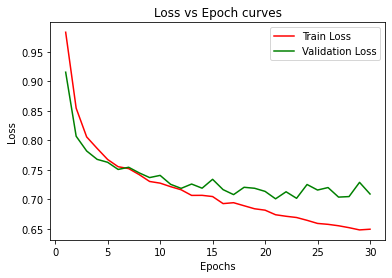

 Accuracy: 70.03%
 f1 score: 69.25%
 Precision: 69.45%
 Recall: 70.03%
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      1065
           1       0.57      0.33      0.42       296
           2       0.66      0.74      0.70       921

    accuracy                           0.70      2282
   macro avg       0.66      0.61      0.63      2282
weighted avg       0.69      0.70      0.69      2282



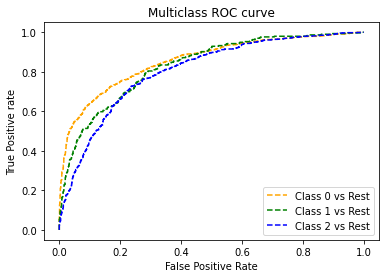

In [ ]:
trainSet = pd.read_csv(train_set_location,index_col=0)  # read csv file and store it to a dataframe
validationSet = pd.read_csv(validation_set_location,index_col=0)  # read csv file and store it to a dataframe


CLEAN_ULR_MENTIONS_NUMBERS = True   # remove urls, mentions and numbers from tweets
CLEAN_STOPWORDS = True # remove stopwords from tweets
CLEAN_EMOJIS = True # convert emojis to the equivelent text
CLEAN_PUNCUATIONS = True  # remove punctuation from tweets
CONVERT_TO_LOWERCASE = True # convert all text to lowercase
LEMMATIZATION = True # apply lemmatization to the tweets
STEMMING = False   # apply stemming to the tweets
   

if(CLEAN_ULR_MENTIONS_NUMBERS):
  trainSet = clean_tweets(trainSet,'tweet') # remove urls, mentions, numbers from all the tweets in the train set
  validationSet = clean_tweets(validationSet,'tweet') # remove urls, mentions, numbers from all the tweets in the validation set
if(CLEAN_EMOJIS or CLEAN_STOPWORDS or CLEAN_PUNCUATIONS or CONVERT_TO_LOWERCASE):
  trainSet = cleanText(trainSet,'tweet')    # clean the tweets of the train set 
  validationSet = cleanText(validationSet,'tweet')    # clean the tweets of the validation set 
if(LEMMATIZATION):
  trainSet = lemmatize_data(trainSet,'tweet') # apply lemmatization to all the tweets of the train set
  validationSet = lemmatize_data(validationSet,'tweet')  # apply lemmatization to all the tweets of the validation set
if(STEMMING):
  trainSet = stem_data(trainSet,'tweet')   # apply stemming to all the tweets of the train set
  validationSet = stem_data(validationSet,'tweet')   # apply stemming to all the tweets of the validation set

X_train = list(trainSet['tweet']) # convert the tweets of the train set into a list
y_train = list(trainSet['label']) # convert the labels of the train set into a list

X_validation = list(validationSet['tweet']) # convert the tweets of the validation set into a list
y_validation = list(validationSet['label']) # convert the labels of the validation set into a list

train_set_transformed = get_tweet_words(X_train,y_train,glove) # tokenize the train set and convert tokens/words to the corresponding embedding index
validation_set_transformed = get_tweet_words(X_validation,y_validation,glove) # tokenize the validation set and convert tokens/words to the corresponding embedding index

# the Attention mechanism implementation
class Attention(nn.Module):
    def __init__(self, dimensions):
        super(Attention, self).__init__()
        # linear input layer with same input and output dimension
        self.linear_in = nn.Linear(dimensions, dimensions, bias=False)
        self.softmax = nn.Softmax(dim=-1) # softmax layer
        # linear output layer that convert the data back to the input dimention
        self.linear_out = nn.Linear(dimensions * 2, dimensions, bias=False)
        self.tanh = nn.Tanh() # tanh activation function

    def forward(self, query, context):
        # we implement self-attetntion so query and context parameters are the same at first
        batch_size, output_len, dimensions = query.size() # find query dimensions
        query_len = context.size(1) # find context length

        query = query.reshape(batch_size * output_len, dimensions) # reshape query
        query = self.linear_in(query) # apply the linear input layer
        query = query.reshape(batch_size, output_len, dimensions) # reshape back query
        # Multiply query and context. for the multiplication we use the Transpose of context.
        # (batch_size, output_len, dimensions) * (batch_size, query_len, dimensions) -> (batch_size, output_len, query_len)
        attention_scores = torch.bmm(query, context.transpose(1, 2).contiguous())

        # Compute weights across every context sequence
        attention_scores = attention_scores.view(batch_size * output_len, query_len)
        attention_weights = self.softmax(attention_scores) # apply softmax to the attention scores in order to compute the weights
        attention_weights = attention_weights.view(batch_size, output_len, query_len)

        # Multiply the attention_weights with the context
        # (batch_size, output_len, query_len) * (batch_size, query_len, dimensions) -> (batch_size, output_len, dimensions)
        mix = torch.bmm(attention_weights, context)
        # concat the output of the previous multiplcation (mix) with the query
        # concat -> (batch_size * output_len, 2*dimensions)
        combined = torch.cat((mix, query), dim=2)
        combined = combined.view(batch_size * output_len, 2 * dimensions)

        # Apply linear_out on every 2nd dimension of concat
        # output -> (batch_size, output_len, dimensions)
        output = self.linear_out(combined).view(batch_size, output_len, dimensions)
        output = self.tanh(output) # apply tanh activation function on the output of the linear output layer

        return output, attention_weights


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_between_layers, final_dropout,bidirectional):
        super(RNN, self).__init__()
        self.num_layers = num_layers # number of stacked layers
        self.hidden_size = hidden_size # hidden size of every layer
        self.emb = nn.Embedding.from_pretrained(glove.vectors) # embedding layer (not trainable) using pre-trained glove word embeddings
        if(num_layers==1): # if we only have one layer, the dropout between stacked layers is not defined
          dropout_between_layers = 0
        if model_type=='LSTM': # if the cell type is set to LSTM
          # we implement 2 stacked LSTM layers
          self.lstm1 = nn.LSTM(input_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) # first LSTM layer
          self.dropout_between_layers = nn.Dropout(dropout_between_layers) # dropout between the stacked LSTM layers
          self.lstm2 = nn.LSTM(2*hidden_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) # second LSTM layer
        elif model_type=='GRU': # if the cell type is set to GRU
          # we implement 2 stacked GRU layers
          self.gru1 = nn.GRU(input_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) # first GRU layer
          self.dropout_between_layers = nn.Dropout(dropout_between_layers) # dropout between the stacked GRU layers
          self.gru2 = nn.GRU(2*hidden_size, hidden_size, 1, batch_first=True,bidirectional=bidirectional) # second GRU layer
      
        self.dropout = nn.Dropout(final_dropout) # dropout layer after the last LSTM/GRU layer
        # initialize Atttention layer
        # the input size of the attention layer is 2 times the output of the LSTM/GRU layer due to skip connection (as we concat the outputs of the 2 LSTM/GRU layers)
        self.attention_layer = Attention(hidden_size*2*2)
        if skip_connections:  # if we apply skip connections
          # the input size of the linear output layer is the same as the input/output size of attention layer
          self.fc = nn.Linear(hidden_size*2*2, num_classes)
        else:
          self.fc = nn.Linear(hidden_size*2, num_classes)  # linear output layer
        
        self._init_weights() # initialize all the weights
        
    def forward(self, x):    
        x = self.emb(x) # create the embeddings of the tweets
        # Set initial hidden states
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(device) 
        if model_type=='LSTM':
          # Set initial cell states for LSTM
          c0 = torch.zeros(2, x.size(0), self.hidden_size).to(device)
          out_lstm1, (h1,c1) = self.lstm1(x, (h0,c0)) # apply the first LSTM layer and save the output
          out_lstm1 = self.dropout_between_layers(out_lstm1) # apply dropout after the first LSTM layer
          # apply the second LSTM layer (giving the output of the first LSTM layer as input) and save the output
          out_lstm1_2, _ = self.lstm2(out_lstm1, (h0,c0))
          out =  out_lstm1_2
        elif model_type=='GRU':
          out_gru1, _ = self.gru1(x, h0) # apply the first GRU layer and save the output
          out_gru1 = self.dropout_between_layers(out_gru1) # apply dropout after the first GRU layer
          # apply the second GRU layer (giving the output of the first GRU layer as input) and save the output
          out_gru2, _ = self.gru2(out_gru1, h0)
          out = out_gru2
        
        if skip_connections and model_type=='LSTM': # if we want to apply skip connections
          # concatenate the output of the first LSTM layer and the output of the second LSTM layer
          out = torch.cat([out, out_lstm1], dim=2)
        elif skip_connections and model_type=='GRU': # if we want to apply skip connections
          # concatenate the output of the first GRU layer and the output of the second GRU layer
          out = torch.cat([out, out_gru1], dim=2)
        
        out = self.dropout(out) # apply dropout to the concatenated output
        attention_out, weights = self.attention_layer(out,out) # apply the attention layer
        attention_out = attention_out[:, -1, :] # reshape the output

        out = self.fc(attention_out) # linear output layer, in order to create output of size 3 (number of classes).
        return out
    
    def _init_weights(self):
        # function that initializes all the model weights
        if model_type=='LSTM':
          layers = [ self.lstm1 , self.lstm2 ]
        elif model_type=='GRU':
          layers = [ self.gru1 , self.gru2 ]
        for layer in layers:
          for param in layer.parameters():
              # Keep track of gradient for backprop
              param.requires_grad_(True)
              # If we deal with weights xavier initialization
              if param.data.ndimension() >= 2:
                  nn.init.xavier_uniform_(param.data) #keep variance stability
              # Else is a bias term so all zeros
              else: 
                nn.init.zeros_(param.data)
              

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
reset_seeds() # reset all random seeds
# Hyper-parameters 
num_classes = 3
num_epochs = 30
batch_size = 16
learning_rate = 0.0001

input_size = EMBEDDING_SIZE
hidden_size = 8
num_layers = 2
dropout_between_layers = 0.5
final_dropout = 0.25
gradient_clipping = True
bidirectional = True
skip_connections = True

model_type = 'GRU'
# create Batchers/DataLoaders for the train and the validation set
train_loader, validation_loader = createDataLoaders(train_set_transformed, validation_set_transformed,batch_size)
# define the model
model = RNN(input_size, hidden_size, num_layers, num_classes,dropout_between_layers,final_dropout,bidirectional).to(device)
print(model)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


train_loss = [] # store the train loss for every epoch
valid_loss = []  # store the validation loss for every epoch
for epoch in range(num_epochs):
  train_batch_losses = [] # store the loss of every batch of the train set
  validation_batch_losses = [] # store the loss of every batch of the validation set
  model.train() # set the model to training mode
  y_total_predict_train = []   # store the predictions of the the train set
  y_total_train = []     # store the labels of the the train set
  train_loader_size = 0
  for x_batch, y_batch in train_loader:
    x_batch = x_batch.to(device) # use gpu
    y_batch = y_batch.to(device) # use gpu
    #Delete previously stored gradients
    optimizer.zero_grad()
    z = model(x_batch)
    loss = criterion(z, y_batch)  # compute the train loss
    train_batch_losses.append(loss.data.item()) # store the train loss of the current batch
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    # Step
    # -----------------------------------
    # Clip params
    if gradient_clipping:
      for param in model.parameters():
          if param.grad is None:
              continue
          grad_val = torch.clamp(param.grad, -5, 5)
    optimizer.step()
    # -----------------------------------
    _, y_pred_tags = torch.max(z, dim = 1)  # get the prediction based on the maximum posibility
    y_total_predict_train = y_total_predict_train+ list(y_pred_tags.cpu()) # store the predictions of the current batch
    y_total_train = y_total_train + (list(y_batch.cpu().detach().numpy())) # store the labels of the current batch
    train_loader_size += 1
  with torch.no_grad():
    correct = 0
    count = 0
    valid_loader_count = 0
    model.eval()   # set the model to evaluation mode
    y_total_valid = []   # store the predictions of the the validation set
    y_total_predict_valid = []      # store the labels of the the validation set
    for x_batch, y_batch in validation_loader:
      y_batch = y_batch.to(device) # use gpu
      x_batch = x_batch.to(device) # use gpu
      z = model(x_batch)
      loss = criterion(z, y_batch)   # compute the validation loss
      validation_batch_losses.append(loss.data.item())   # store the validation loss of the current batch
      _, label = torch.max(z,1)    # get the label prediction based on the maximum posibility
      correct += (label==y_batch).sum().item()    # compute how many corect preditions were made
      count += len(y_batch)
      y_total_predict_valid = y_total_predict_valid+ list(label.cpu()) # store the predictions of the current batch
      y_total_valid= y_total_valid + list(y_batch.cpu().detach().numpy()) # store the labels of the current batch
      valid_loader_count += 1
  accuracy = 100*(correct/(count))  # compute validation accuracy based on the correct predictions
  current_train_loss = sum(train_batch_losses)/train_loader_size  #compute the train loss of this epoch
  train_loss.append(current_train_loss)   # store the train loss in order to plot loss curves
  current_valid_loss = sum(validation_batch_losses)/valid_loader_count   #compute the validation loss of this epoch
  valid_loss.append(current_valid_loss)   # store the validation loss in order to plot loss curves
  f1_score_train = f1_score(y_total_train,y_total_predict_train,average='weighted')# compure train f1-score
  f1_score_valid = f1_score(y_total_valid,y_total_predict_valid,average='weighted') # compure validation f1-score
  print(f"Epoch {epoch:3}: Train Loss = {current_train_loss:.5f} | Validation Loss = {current_valid_loss:.5f} | Accuracy = {accuracy:.4f} | Train-f1 = {f1_score_train:.4f} | Valid-F1 = {f1_score_valid:.4f}")

# plot the loss vs epochs curves
plot_loss_curves(train_loss,valid_loss,num_epochs) 

with torch.no_grad():
  model.eval()   # set the model to evaluation mode
  y_total_valid = []   # store the predictions of the the validation set
  y_total_predict_valid = []      # store the labels of the the validation set
  y_output = []
  for x_batch, y_batch in validation_loader:
    x_batch = x_batch.to(device) # use gpu
    y_batch = y_batch.to(device) # use gpu
    z = model(x_batch)
    _, label = torch.max(z,1)    # get the label prediction based on the maximum posibility
    y_output = y_output + list(z.cpu().detach().numpy())
    y_total_predict_valid = y_total_predict_valid+ list(label.cpu()) # store the predictions of the current batch
    y_total_valid= y_total_valid + list(y_batch.cpu().detach().numpy()) # store the labels of the current batch


# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

y_output = np.array(y_output)
n_class = 3  # number of classes/labels

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_total_valid, y_output[:,i], pos_label=i)
    
# plotting the ROC curves
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  

y_pred_tags = y_total_predict_valid
accuracy_countVec = accuracy_score(y_total_valid,y_pred_tags)  # accuracy metric
f1_score_countVec = f1_score(y_total_valid,y_pred_tags,average='weighted') # f1_score metric
print(" Accuracy: %.2f%%" %(accuracy_countVec*100))
print(" f1 score: %.2f%%" %(f1_score_countVec*100))
print(' Precision: %.2f%%' % (precision_score(y_total_valid, y_pred_tags,average='weighted')*100)) # precision
print(' Recall: %.2f%%' % (recall_score(y_total_valid, y_pred_tags,average='weighted')*100)) # recall
print(classification_report(y_total_valid, y_pred_tags))